In [25]:
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential, Model #Fixed: Changed import to be from tensorflow.keras
from tensorflow.keras.models import Sequential, Model
#from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input, Concatenate, Average #Fixed: Changed import to be from tensorflow.keras
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input, Concatenate, Average
#from keras.optimizers import Adam #Fixed: Changed import to be from tensorflow.keras
from tensorflow.keras.optimizers import Adam
#from keras.metrics import categorical_crossentropy #Fixed: Changed import to be from tensorflow.keras
from tensorflow.keras.metrics import categorical_crossentropy
#from keras.preprocessing.image import ImageDataGenerator #Fixed: Changed import to use tf.keras.preprocessing.image_dataset_from_directory and tf.keras.utils.image_dataset_from_directory
import tensorflow.keras.preprocessing # Fixed - add this import to avoid tf error
from tensorflow.keras.preprocessing import image # Fixed - add this import to avoid tf error
from tensorflow.keras.utils import image_dataset_from_directory
# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
#from keras.callbacks import ReduceLROnPlateau, EarlyStopping #Fixed: Changed import to be from tensorflow.keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Found 604 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


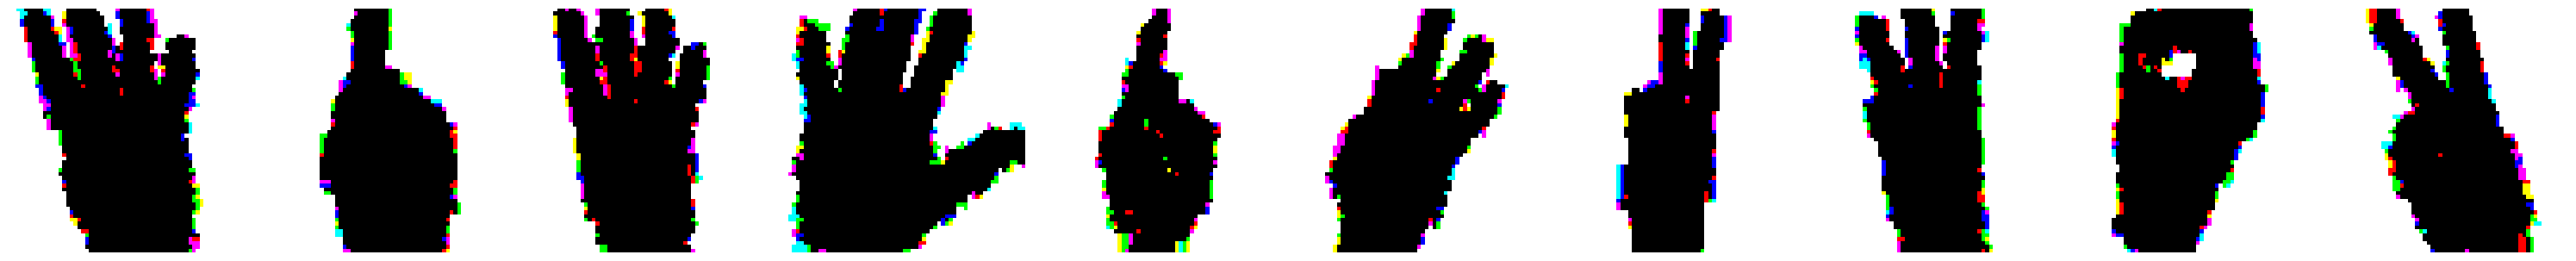

(10, 64, 64, 3)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Training Custom CNN...
Epoch 1/10
61/61 [==============================] - 4s 43ms/step - loss: 2.2269 - accuracy: 0.1755 - val_loss: 2.1343 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 2/10
61/61 [==============================] - 2s 41ms/step - loss: 1.6138 - accuracy: 0.3758 - val_loss: 1.1856 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 3/10
61/61 [==============================] - 2s 39ms/step - loss: 1.0159 - accuracy: 0.6225 - val_loss: 0.5460 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/10
61/61 [==============================] - 2s 39ms/step - loss: 0.7083 - accuracy: 0.7483 - val_loss: 0.2897 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 5/10
61/

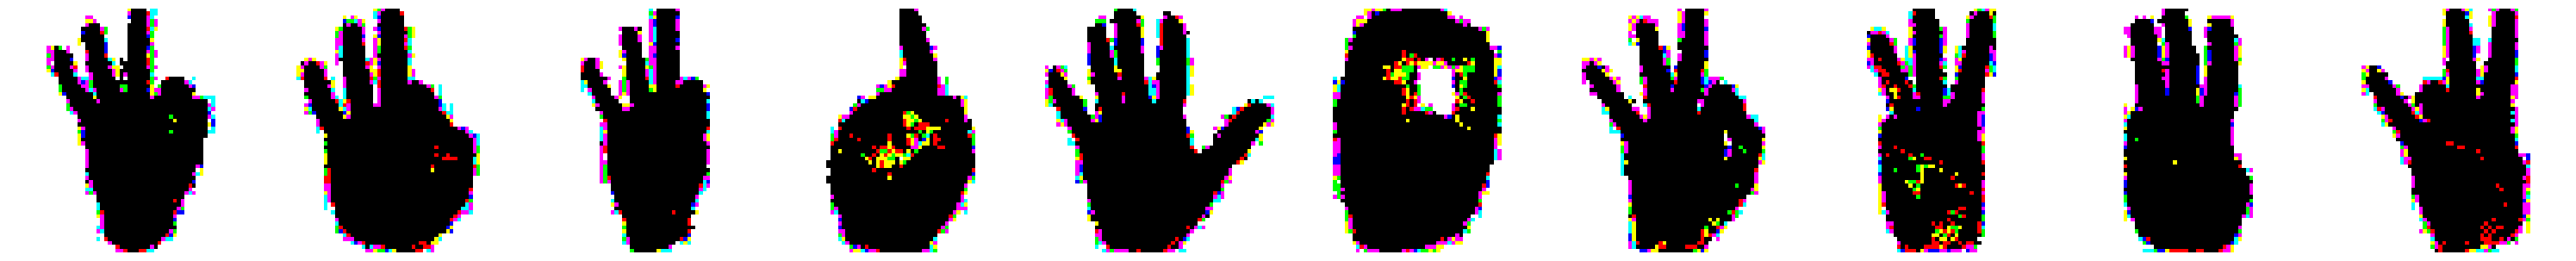

Actual labels:
Nine   Nine   Nine   One   Five   Zero   Nine   Six   Six   Seven   (10, 64, 64, 3)


In [26]:
# Paths to your dataset
train_path = r'Dataset/Train'  # Update to your train folder
test_path = r'Dataset/Test'  # Update to your test folder


# Load data using ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,  # Use MobileNet preprocessing
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_batches = train_datagen.flow_from_directory(
    directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)
test_batches = test_datagen.flow_from_directory(
    directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

imgs, labels = next(train_batches)

# Plotting the images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(imgs.shape)
print(labels)

# Define the custom CNN model
def create_custom_cnn():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    return model

# Define the MobileNetV2 model
def create_mobilenet():
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(64,64,3))
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(10, activation="softmax")(x)
    model = Model(inputs, outputs)
    return model

# Create both models
custom_cnn = create_custom_cnn()
mobilenet = create_mobilenet()

# Compile both models
custom_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

# Train the custom CNN
print("Training Custom CNN...")
history_cnn = custom_cnn.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop], validation_data=test_batches)

# Train MobileNetV2
print("Training MobileNetV2...")
history_mobilenet = mobilenet.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop], validation_data=test_batches)

# Create the ensemble model
inputs = Input(shape=(64, 64, 3))
cnn_output = custom_cnn(inputs)
mobilenet_output = mobilenet(inputs)
ensemble_output = Average()([cnn_output, mobilenet_output])
ensemble_model = Model(inputs=inputs, outputs=ensemble_output)

ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the ensemble model on a test batch
imgs, labels = next(test_batches)
scores = ensemble_model.evaluate(imgs, labels, verbose=0)
print(f'Ensemble Model: {ensemble_model.metrics_names[0]} of {scores[0]}; {ensemble_model.metrics_names[1]} of {scores[1]*100}%')

# Save the individual models (we'll load them separately for inference)
custom_cnn.save('custom_cnn.h5')
mobilenet.save('custom_mobilenet.h5')

# Print training history
print("Custom CNN History:", history_cnn.history)
print("MobileNetV2 History:", history_mobilenet.history)

# Define word dictionary
word_dict = {0:'Zero', 1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine'}

# Predict on test batch using the ensemble model
predictions = ensemble_model.predict(imgs, verbose=0)
print("Ensemble Predictions on a small set of test data:")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels:')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

print(imgs.shape)

In [27]:
# Access accuracy from the training history
cnn_accuracy = history_cnn.history['accuracy'][-1]  # Get the last epoch's accuracy
mobilenet_accuracy = history_mobilenet.history['accuracy'][-1]

print(f"Custom CNN Accuracy: {cnn_accuracy:.4f}")
print(f"MobileNetV2 Accuracy: {mobilenet_accuracy:.4f}")

Custom CNN Accuracy: 0.9570
MobileNetV2 Accuracy: 0.9272


In [28]:
# Evaluate on the test data
cnn_loss, cnn_accuracy = custom_cnn.evaluate(test_batches, verbose=0)
mobilenet_loss, mobilenet_accuracy = mobilenet.evaluate(test_batches, verbose=0)

print(f"Custom CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"MobileNetV2 Test Accuracy: {mobilenet_accuracy:.4f}")

Custom CNN Test Accuracy: 1.0000
MobileNetV2 Test Accuracy: 0.8300


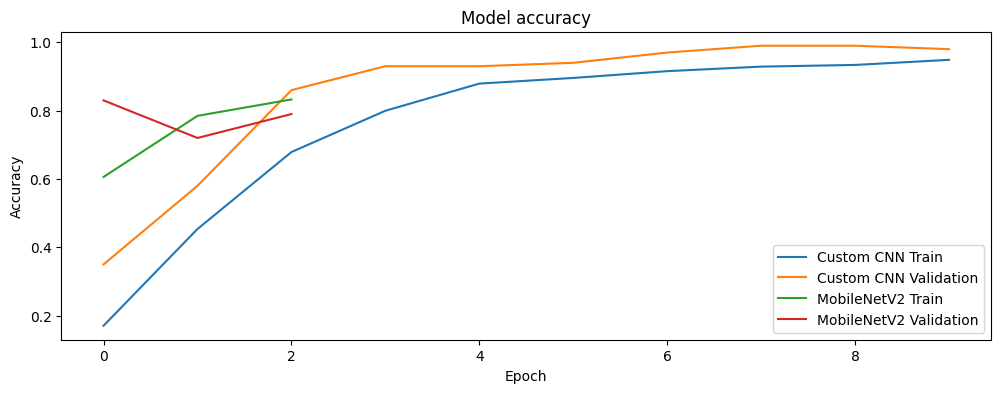

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.plot(history_cnn.history['accuracy'], label='Custom CNN Train')
plt.plot(history_cnn.history['val_accuracy'], label='Custom CNN Validation')
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

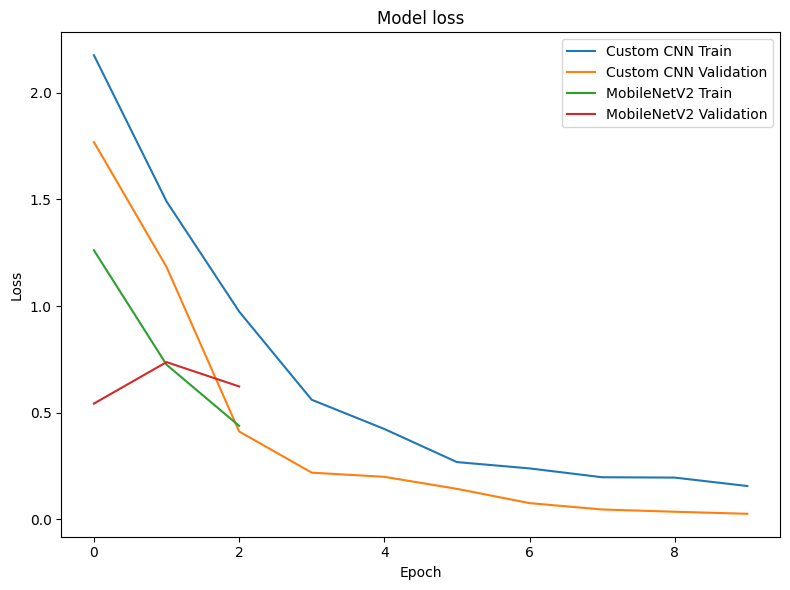

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history_cnn.history['loss'], label='Custom CNN Train')
plt.plot(history_cnn.history['val_loss'], label='Custom CNN Validation')
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Text(0.5, 1.0, 'Custom CNN Confusion Matrix')

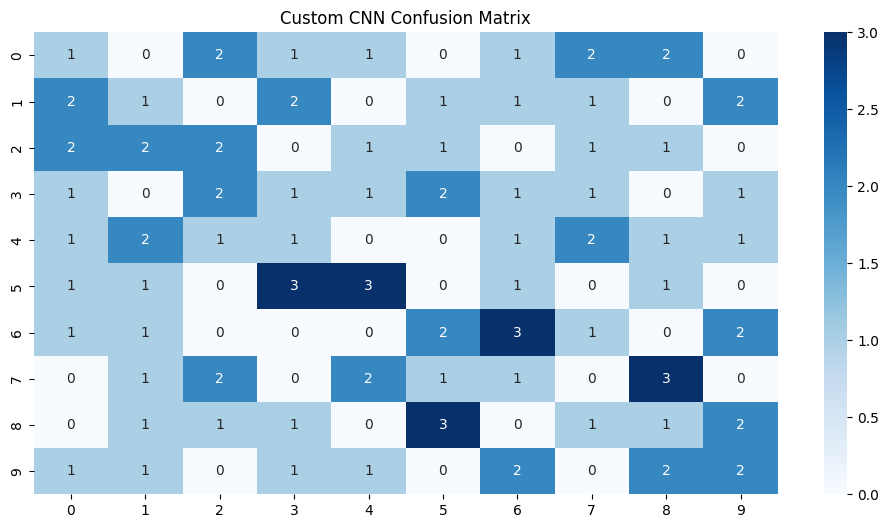

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

  # Get predictions on the test set
y_pred_cnn = custom_cnn.predict(test_batches)
y_pred_mobilenet = mobilenet.predict(test_batches)
y_true = test_batches.classes  # Assuming test_batches has a 'classes' attribute

  # Calculate confusion matrices
cm_cnn = confusion_matrix(y_true, y_pred_cnn.argmax(axis=1))
cm_mobilenet = confusion_matrix(y_true, y_pred_mobilenet.argmax(axis=1))

  # Plot confusion matrices
plt.figure(figsize=(12, 6))

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('Custom CNN Confusion Matrix')

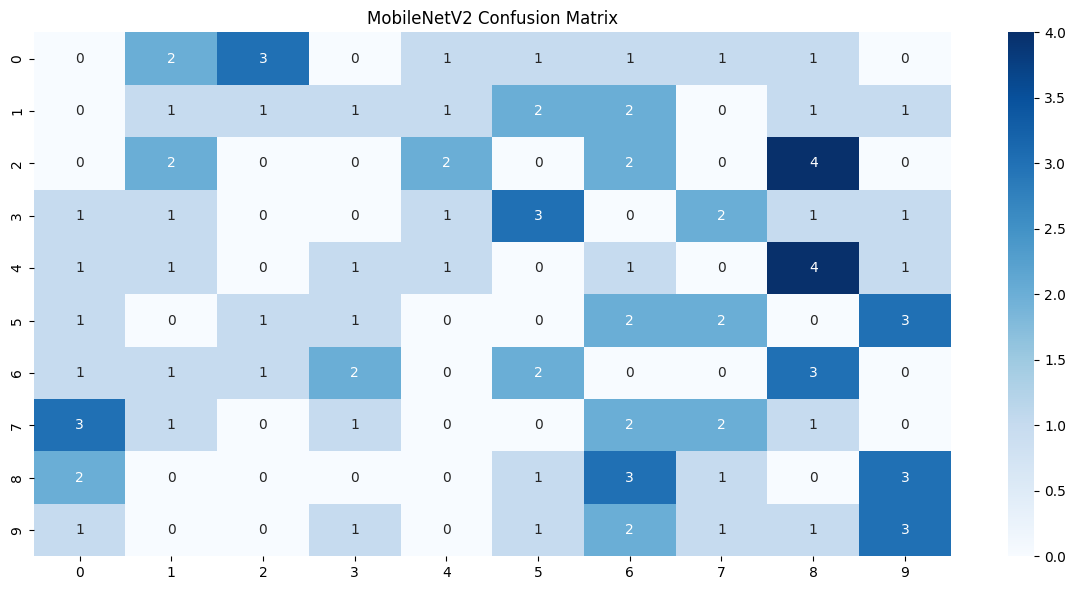

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues')
plt.title('MobileNetV2 Confusion Matrix')
plt.tight_layout()
plt.show()